In [1]:
#importing basic libraries
import numpy as np
import pandas as pd

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
!pip install Livelossplot
from livelossplot import PlotLossesKeras

In [2]:
#Mounting Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#check columns names
info=pd.read_csv('/content/drive/MyDrive/Dataset/Info.txt', sep=" ")
info=info.drop('Unnamed: 7',axis=1)
info.SEVERITY.fillna(0)
info.head(10)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
5,mdb005,F,CIRC,B,500.0,168.0,26.0
6,mdb006,F,NORM,NaN,NaN,NaN,NaN
7,mdb007,G,NORM,NaN,NaN,NaN,NaN
8,mdb008,G,NORM,NaN,NaN,NaN,NaN
9,mdb009,F,NORM,NaN,NaN,NaN,NaN


In [ ]:
info.axes

[RangeIndex(start=0, stop=330, step=1),
 Index(['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS'], dtype='object')]

In [3]:
#importing all libraries
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
#from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

print("All modules have been imported")


All modules have been imported


<Axes: ylabel='CLASS'>

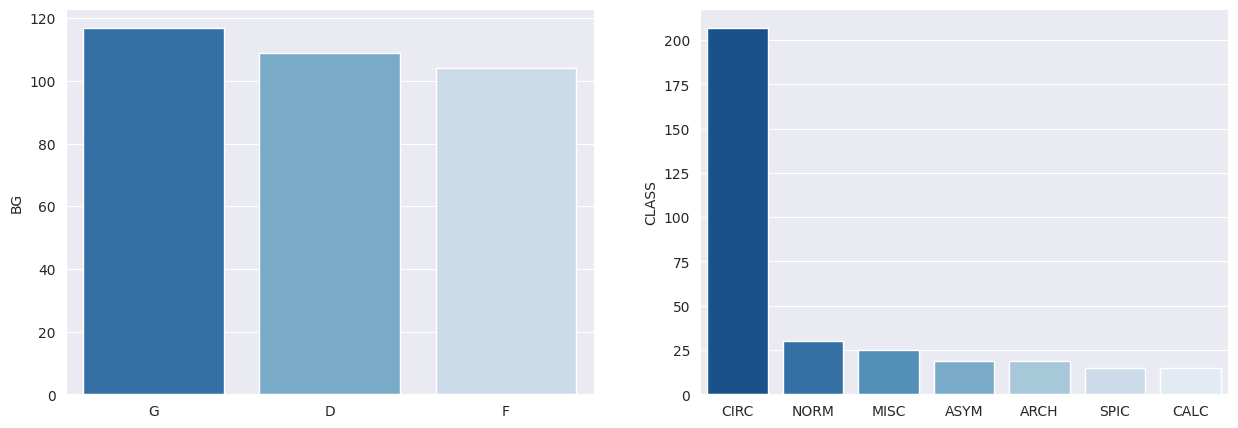

In [ ]:
#comparing various features

sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=info.BG.unique() , y=info.BG.value_counts() , palette='Blues_r',ax=ax1)
sns.barplot(x=info.CLASS.unique() , y=info.CLASS.value_counts() , palette='Blues_r',ax=ax2)

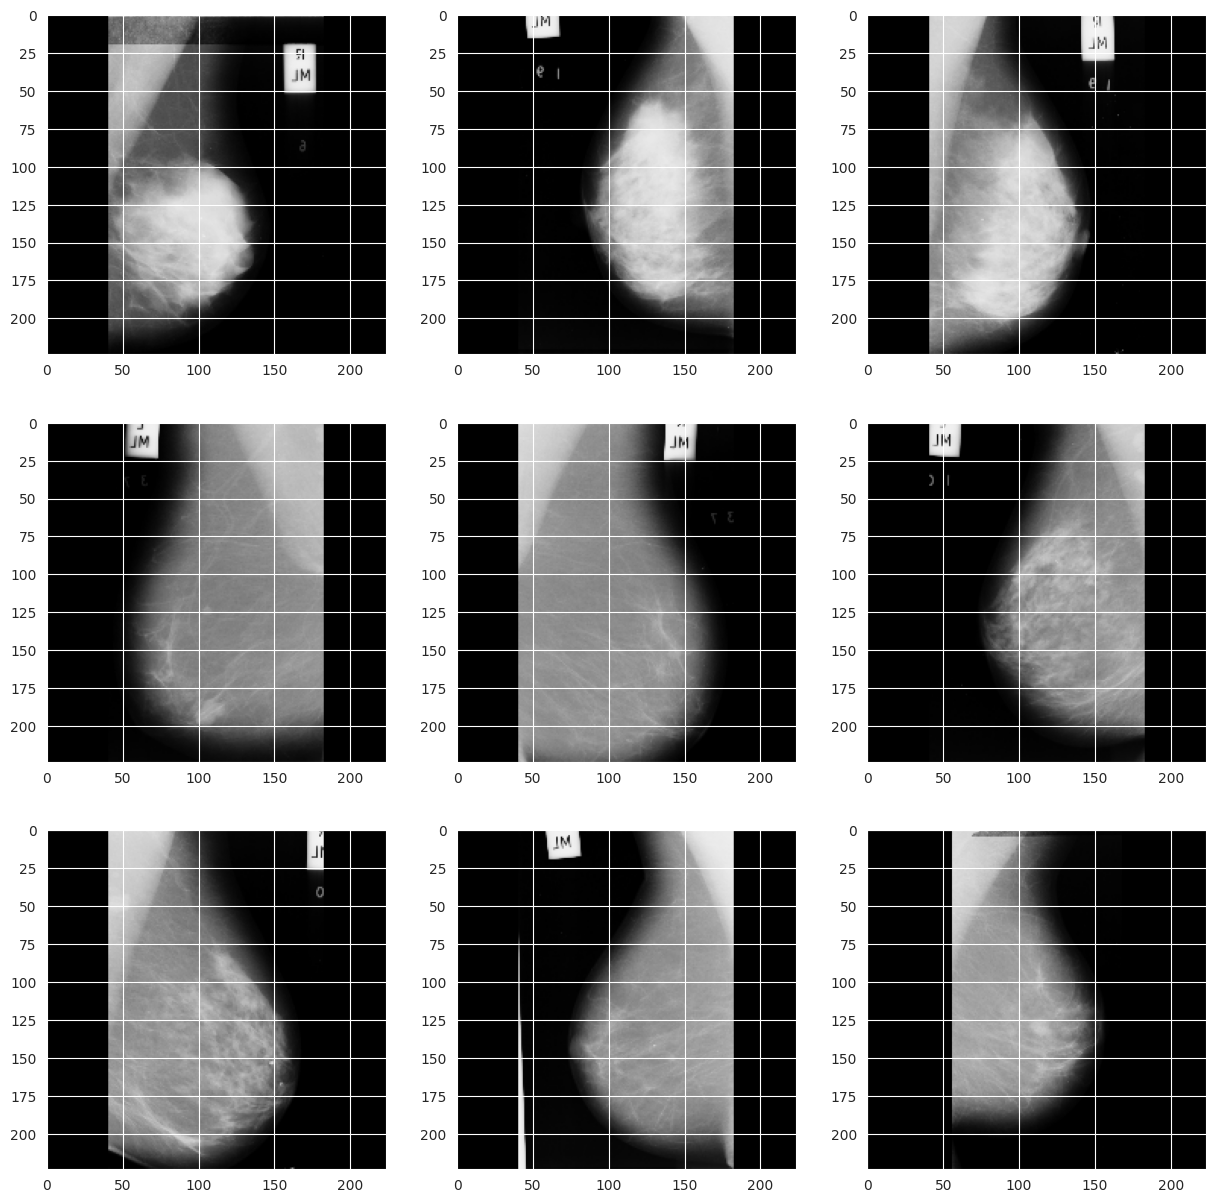

In [ ]:
#Plotting images
from PIL import Image
import glob # used to search similar images
x= []
for filename in sorted(glob.glob("/content/drive/MyDrive/Dataset/all-mias/*.pgm")):
    img=cv2.imread(filename)  #to read file
    img =cv2.resize(img,(224, 224))
    x.append(img)
fig=plt.figure(figsize=(15,15))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i])
plt.show()

Defining some helper functions

In [4]:
# Image Augmentation
no_angles = 360
url = '/content/drive/MyDrive/Dataset/all-mias/'

def save_dictionary(path,data):
        print('saving catalog...')
        #open('u.item', encoding="utf-8")
        import json
        with open(path,'w') as outfile:
            json.dump(str(data), fp=outfile)
        # save to file:
        print(' catalog saved')

In [5]:
#train_test_split_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
#val_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
#test_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
def read_image():
        url='/content/drive/MyDrive/Dataset/all-mias/'
        print("Reading images")
        import cv2
        info = {}
        for i in range(322):
            if i<9:
                image_name='mdb00'+str(i+1)
            elif i<99:
                image_name='mdb0'+str(i+1)
            else:
                image_name = 'mdb' + str(i+1)
            image_address= url+image_name+'.pgm'
            img = cv2.imread(image_address,1)
            #try:
            img = cv2.resize(img, (224,224))
            #except:
                #break
            rows, cols,channel = img.shape
            info[image_name]={}
            for angle in range(0,no_angles,8):
                M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
                img_rotated = cv2.warpAffine(img, M, (cols, rows))
                info[image_name][angle]=img_rotated
        return (info)

In [6]:
def read_label():
    print("Reading labels")
    filename = '/content/drive/MyDrive/Dataset/Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')
        if len(words)>3:
            if (words[3] == 'B'):
                info[words[0]] = {}
                for angle in range(0,no_angles,8):
                    info[words[0]][angle] = 0
            if (words[3] == 'M'):
                info[words[0]] = {}
                for  angle in range(0,no_angles,8):
                    info[words[0]][angle] = 1
    return (info)

Splitting training and testing data

In [ ]:
import numpy as np
label_info=read_label()
image_info=read_image()
ids=label_info.keys()
#del lable_info['Truth-Data:']
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(str(image_info[id][angle]))
        Y.append(label_info[id][angle])
X=np.array(X)
Y=np.array(Y)
Y=to_categorical(Y,2)

#print(X.shape)
#print(Y.shape)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))


Reading labels
Reading images
3622 1087 466


MODEL 1:
ResNet50

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
label_info=read_label()
image_info=read_image()
#print(image_info[1][0])
ids=label_info.keys()   #ids = acceptable labeled ids
#print(type(ids))
#del label_info['Truth-Data:']
#print(lable_info)
#print(ids)
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(label_info[id][angle])
X=np.array(X)
Y=np.array(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2021,shuffle=True)

Reading labels
Reading images


In [ ]:
rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

for layer in base_model.layers:
  layer.trainable = False

model.summary()

(224, 224, 3)
94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                            

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=4,restore_best_weights=True, verbose=1)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=20, batch_size=32,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

save_dictionary('history1.dat', history.history)

Epoch 1/20
97/97 [==============================] - 471s 5s/step - loss: 0.8592 - accuracy: 0.4971 - val_loss: 0.7034 - val_accuracy: 0.5827
Epoch 2/20
97/97 [==============================] - 470s 5s/step - loss: 0.7901 - accuracy: 0.5231 - val_loss: 0.6548 - val_accuracy: 0.6232
Epoch 3/20
97/97 [==============================] - 472s 5s/step - loss: 0.7363 - accuracy: 0.5601 - val_loss: 0.6303 - val_accuracy: 0.6654
Epoch 4/20
97/97 [==============================] - 481s 5s/step - loss: 0.6654 - accuracy: 0.6166 - val_loss: 0.5857 - val_accuracy: 0.7132
Epoch 5/20
97/97 [==============================] - 469s 5s/step - loss: 0.5913 - accuracy: 0.6842 - val_loss: 0.5249 - val_accuracy: 0.7390
Epoch 6/20
97/97 [==============================] - 474s 5s/step - loss: 0.5265 - accuracy: 0.7229 - val_loss: 0.4501 - val_accuracy: 0.7978
Epoch 7/20
97/97 [==============================] - 474s 5s/step - loss: 0.4648 - accuracy: 0.7758 - val_loss: 0.4598 - val_accuracy: 0.7923
Epoch 8/20
97

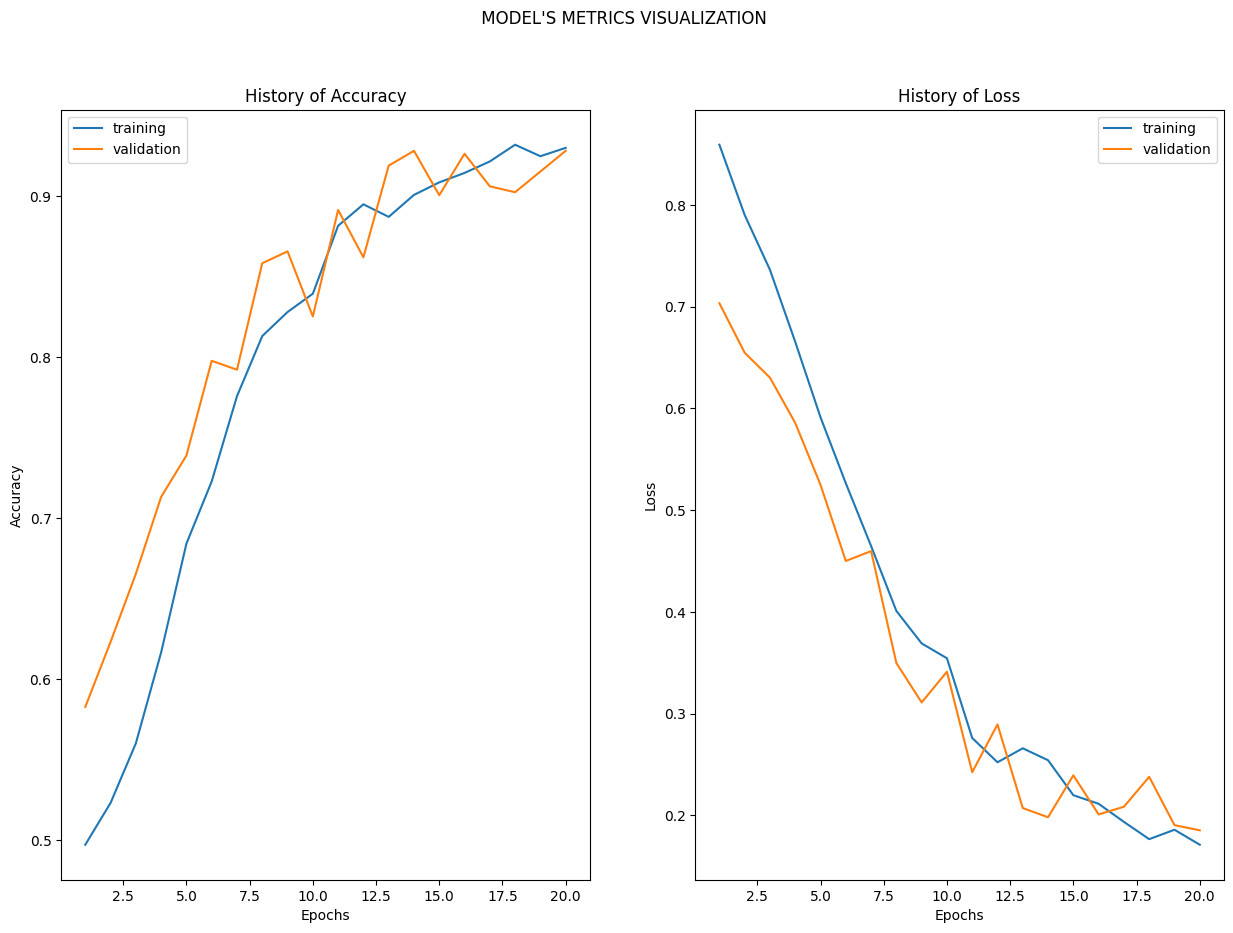

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [ ]:
y_pred=model.predict(x_test)
#y_pred_prb=model.predict_proba(x_test)

49/49 [==============================] - 206s 4s/step


In [ ]:
target=["B","M"]
from sklearn import metrics
#accuracy_score(y_true, y_pred.round(), normalize=False)
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred.round(),),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred.round(), average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred.round(), average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred.round(), average='weighted'),4))
#print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
#print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred.round(),target_names=target))

a1=np.round(metrics.accuracy_score(y_test, y_pred.round(),),4)
p1=np.round(metrics.precision_score(y_test, y_pred.round(), average='weighted'),4)
r1=np.round(metrics.recall_score(y_test,y_pred.round(), average='weighted'),4)
f1= np.round(metrics.f1_score(y_test, y_pred.round(), average='weighted'),4)


Accuracy: 0.9137
Precision: 0.9143
Recall: 0.9137
F1 Score: 0.9135
		Classification Report:
               precision    recall  f1-score   support

           B       0.90      0.94      0.92       845
           M       0.93      0.88      0.90       708

    accuracy                           0.91      1553
   macro avg       0.92      0.91      0.91      1553
weighted avg       0.91      0.91      0.91      1553



In [17]:
a1,p1,r1,f1= 0.9137 ,0.9143 ,0.9137 ,0.9135

### MODEL 2:
VGG-16

In [ ]:
def read_label():
    print("Reading labels")
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')
        if len(words)>3:
            if (words[3] == 'B'):
                info[words[0]] = {}
                for angle in range(0,no_angles,8):
                    info[words[0]][angle] = 0
            if (words[3] == 'M'):
                info[words[0]] = {}
                for  angle in range(0,no_angles,8):
                    info[words[0]][angle] = 1
        if len(words)>2:
            if (words[2] == 'NORM'):
                info[words[0]] = {}
                for angle in range(0,no_angles,8):
                    info[words[0]][angle] = 2

    return (info)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
label_info=read_label()
image_info=read_image()
#print(image_info[1][0])
ids=label_info.keys()   #ids = acceptable labeled ids
#print(type(ids))
del label_info['Truth-Data:']
#print(lable_info)
#print(ids)
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(label_info[id][angle])
X=np.array(X)
Y=np.array(Y)
Y=to_categorical(Y,3)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2021,shuffle=True)

Reading labels
Reading images


In [ ]:
#%% BALANCING THE DATA DURING TRAIN
from sklearn.utils import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight
y_integers = np.argmax(y_train, axis=1)
#class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_integers), y= y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

{0: 1.6989949748743718, 1: 2.0986964618249533, 2: 0.51681442983797}


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

rows, cols,color = x_train[0].shape
print(x_train[0].shape)

base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

(224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                         

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,restore_best_weights=True, verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=9, batch_size=32,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

save_dictionary('history1.dat', history.history)

Epoch 1/9
270/270 [==============================] - 69s 191ms/step - loss: 0.9942 - accuracy: 0.6003 - val_loss: 0.6579 - val_accuracy: 0.7254
Epoch 2/9
270/270 [==============================] - 47s 174ms/step - loss: 0.6224 - accuracy: 0.7436 - val_loss: 0.5441 - val_accuracy: 0.7819
Epoch 3/9
270/270 [==============================] - 48s 179ms/step - loss: 0.4693 - accuracy: 0.8177 - val_loss: 0.4972 - val_accuracy: 0.8226
Epoch 4/9
270/270 [==============================] - 48s 177ms/step - loss: 0.3987 - accuracy: 0.8407 - val_loss: 0.4666 - val_accuracy: 0.8390
Epoch 5/9
270/270 [==============================] - 52s 194ms/step - loss: 0.3392 - accuracy: 0.8671 - val_loss: 0.4401 - val_accuracy: 0.8443
Epoch 6/9
270/270 [==============================] - 52s 194ms/step - loss: 0.2893 - accuracy: 0.8895 - val_loss: 0.3951 - val_accuracy: 0.8614
Epoch 7/9
270/270 [==============================] - 52s 194ms/step - loss: 0.2664 - accuracy: 0.8972 - val_loss: 0.4122 - val_accuracy:

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [ ]:
y_pred=model.predict(x_test)
y_test=[np.argmax(x) for x in y_test]

In [ ]:
y_test_arg=np.argmax(y_test,axis=0)
y_pred = np.argmax(model.predict(x_test),axis=1)
print('Confusion Matrix')
#print(confusion_matrix(y_test_arg, y_pred))

In [ ]:
target=["B","M"]
from sklearn import metrics
#accuracy_score(y_true, y_pred.round(), normalize=False)
#print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred.round(),),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred.round(), average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred.round(), average='weighted'),4))
#print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
#print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred.round(),target_names=target))


p2=np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4)
r2=np.round(metrics.recall_score(y_test,y_pred.round(), average='weighted'),4)
f2=np.round(metrics.f1_score(y_test, y_pred.round(), average='weighted'),4)

In [15]:
a2,p2,r2,f2= 0.9514,0.9515 ,0.9514 ,0.9516

### MODEL 3:
DenseNet169

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
label_info=read_label()
image_info=read_image()
#print(image_info[1][0])
ids=label_info.keys()   #ids = acceptable labeled ids
#print(type(ids))
#del label_info['Truth-Data:']
#print(lable_info)
#print(ids)
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(label_info[id][angle])
X=np.array(X)
Y=np.array(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=2021,shuffle=True)
# cancer_prediction_cnn(x_train, y_train, x_test, y_test)

Reading labels
Reading images


In [8]:
base_model = DenseNet169(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()
(224, 224, 3)

51877672/51877672 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (Batch  (None, 81536)             326144    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              83493888  
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              40

(224, 224, 3)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=8,restore_best_weights=True, verbose=1)

In [10]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=10, batch_size=32,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

save_dictionary('history1.dat', history.history)

Epoch 1/10
117/117 [==============================] - 63s 256ms/step - loss: 0.8195 - accuracy: 0.5581 - val_loss: 0.8840 - val_accuracy: 0.5682
Epoch 2/10
117/117 [==============================] - 20s 171ms/step - loss: 0.6105 - accuracy: 0.6742 - val_loss: 0.6727 - val_accuracy: 0.6667
Epoch 3/10
117/117 [==============================] - 20s 169ms/step - loss: 0.4676 - accuracy: 0.7793 - val_loss: 0.5499 - val_accuracy: 0.7318
Epoch 4/10
117/117 [==============================] - 20s 170ms/step - loss: 0.3792 - accuracy: 0.8368 - val_loss: 0.5026 - val_accuracy: 0.7667
Epoch 5/10
117/117 [==============================] - 19s 164ms/step - loss: 0.2800 - accuracy: 0.8801 - val_loss: 0.5527 - val_accuracy: 0.7667
Epoch 6/10
117/117 [==============================] - 20s 171ms/step - loss: 0.2277 - accuracy: 0.9024 - val_loss: 0.4590 - val_accuracy: 0.8212
Epoch 7/10
117/117 [==============================] - 20s 173ms/step - loss: 0.1869 - accuracy: 0.9275 - val_loss: 0.3663 - val_ac

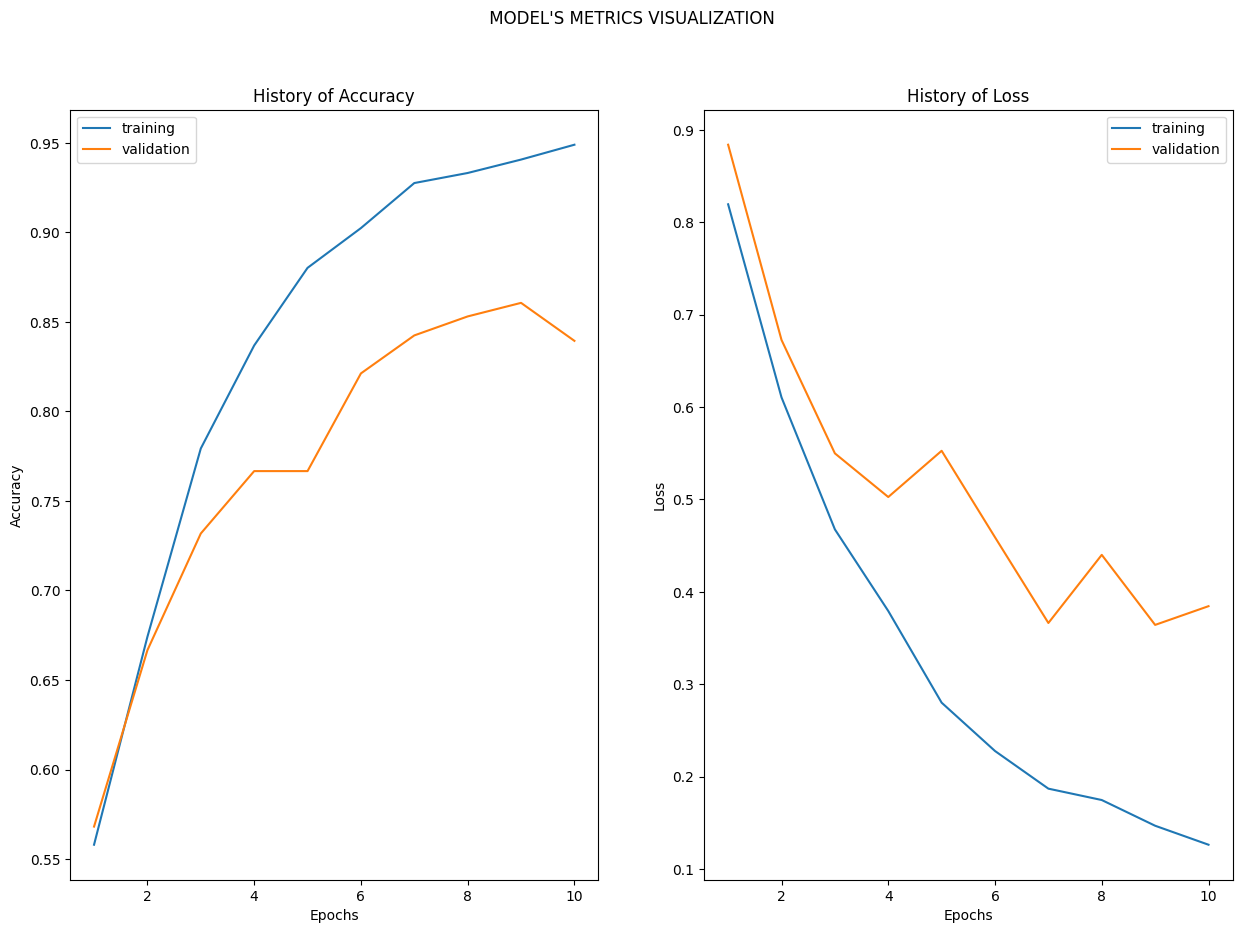

In [11]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])


In [12]:
y_pred=model.predict(x_test)


25/25 [==============================] - 7s 141ms/step


In [13]:
target=["B","M"]
from sklearn import metrics
#accuracy_score(y_true, y_pred.round(), normalize=False)
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred.round(),),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred.round(), average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred.round(), average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred.round(), average='weighted'),4))
#print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
#print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred.round(),target_names=target))

a3=np.round(metrics.accuracy_score(y_test, y_pred.round(),),4)
p3=np.round(metrics.precision_score(y_test, y_pred.round(), average='weighted'),4)
r3=np.round(metrics.recall_score(y_test,y_pred.round(), average='weighted'),4)
f3=np.round(metrics.f1_score(y_test, y_pred.round(), average='weighted'),4)

Accuracy: 0.8417
Precision: 0.8452
Recall: 0.8417
F1 Score: 0.8419
		Classification Report:
               precision    recall  f1-score   support

           B       0.88      0.81      0.85       418
           M       0.80      0.87      0.84       359

    accuracy                           0.84       777
   macro avg       0.84      0.84      0.84       777
weighted avg       0.85      0.84      0.84       777



In [14]:
a3,p3,r3,f3=0.8417,0.8452,0.8417,0.8419

In [ ]:
# Define a color palette using Seaborn
palette = sns.color_palette("husl", len(compare_results))

# Assuming you have a DataFrame called compare_results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh", color=palette)

plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.title("Model Accuracy")
plt.show()

In [ ]:
a=[[],[],[]]

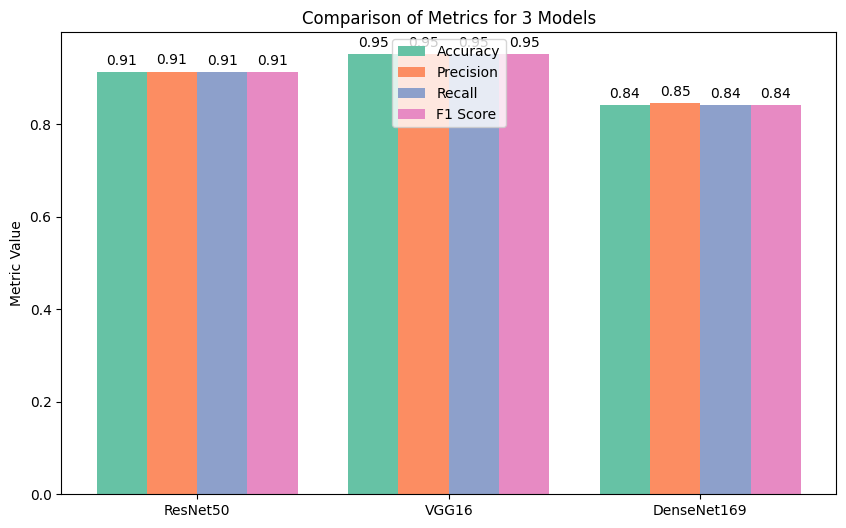

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Model names and metric names
model_names = ['ResNet50','VGG16','DenseNet169']
metric_names = [ 'Accuracy', 'Precision','Recall', 'F1 Score']

# Metric values for each model
values = np.array([
    [a1, p1, r1, f1],
    [a2, p2, r2, f2],
    [a3,p3,r3,f3]
])

# Define bar width
bar_width = 0.2
index = np.arange(len(model_names))

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Use Seaborn's "viridis" color palette for distinct colors
palette = sns.color_palette("Set2")

for i, metric_name in enumerate(metric_names):
    bars = ax.bar(index + i * bar_width, values[:, i], bar_width, label=metric_name, color=palette[i])
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format the value to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # Position to annotate
                    xytext=(0, 3),  # Offset to adjust the text position
                    textcoords="offset points",
                    ha='center', va='bottom')

# Set the x-axis labels
ax.set_xticks(index + bar_width * (len(metric_names) - 1) / 2)
ax.set_xticklabels(model_names)

# Set the y-axis label
ax.set_ylabel('Metric Value')

# Set the chart title
ax.set_title('Comparison of Metrics for 3 Models')

# Adjust the legend location
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1))

# Show the grouped bar chart
plt.show()
